In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  %pip install --quiet git+https://github.com/raultruco/cryptowatson-indicators#egg=cryptowatson-indicators

from cryptowatsonindicators import fng
import requests
requests.packages.urllib3.disable_warnings()

### API key variables

In [2]:
binance_api_key = ''
binance_secret_key = ''

### Simulator variables

In [3]:
# time_frame = "day"
ticker_symbol = "BTCUSDT"    # currently only works with BTCUSDT
# weight_type = "fibs"   # "fibs" or "originaldca"
# dcaAmount = 100

### Current Fear and Greed

In [4]:
current_fng = fng.get_current_fng()
print(current_fng)

{'date': Timestamp('2022-08-07 00:00:00'), 'fng_value': 30, 'fng_name': 'Fear'}


### Plot Fear and Greed History

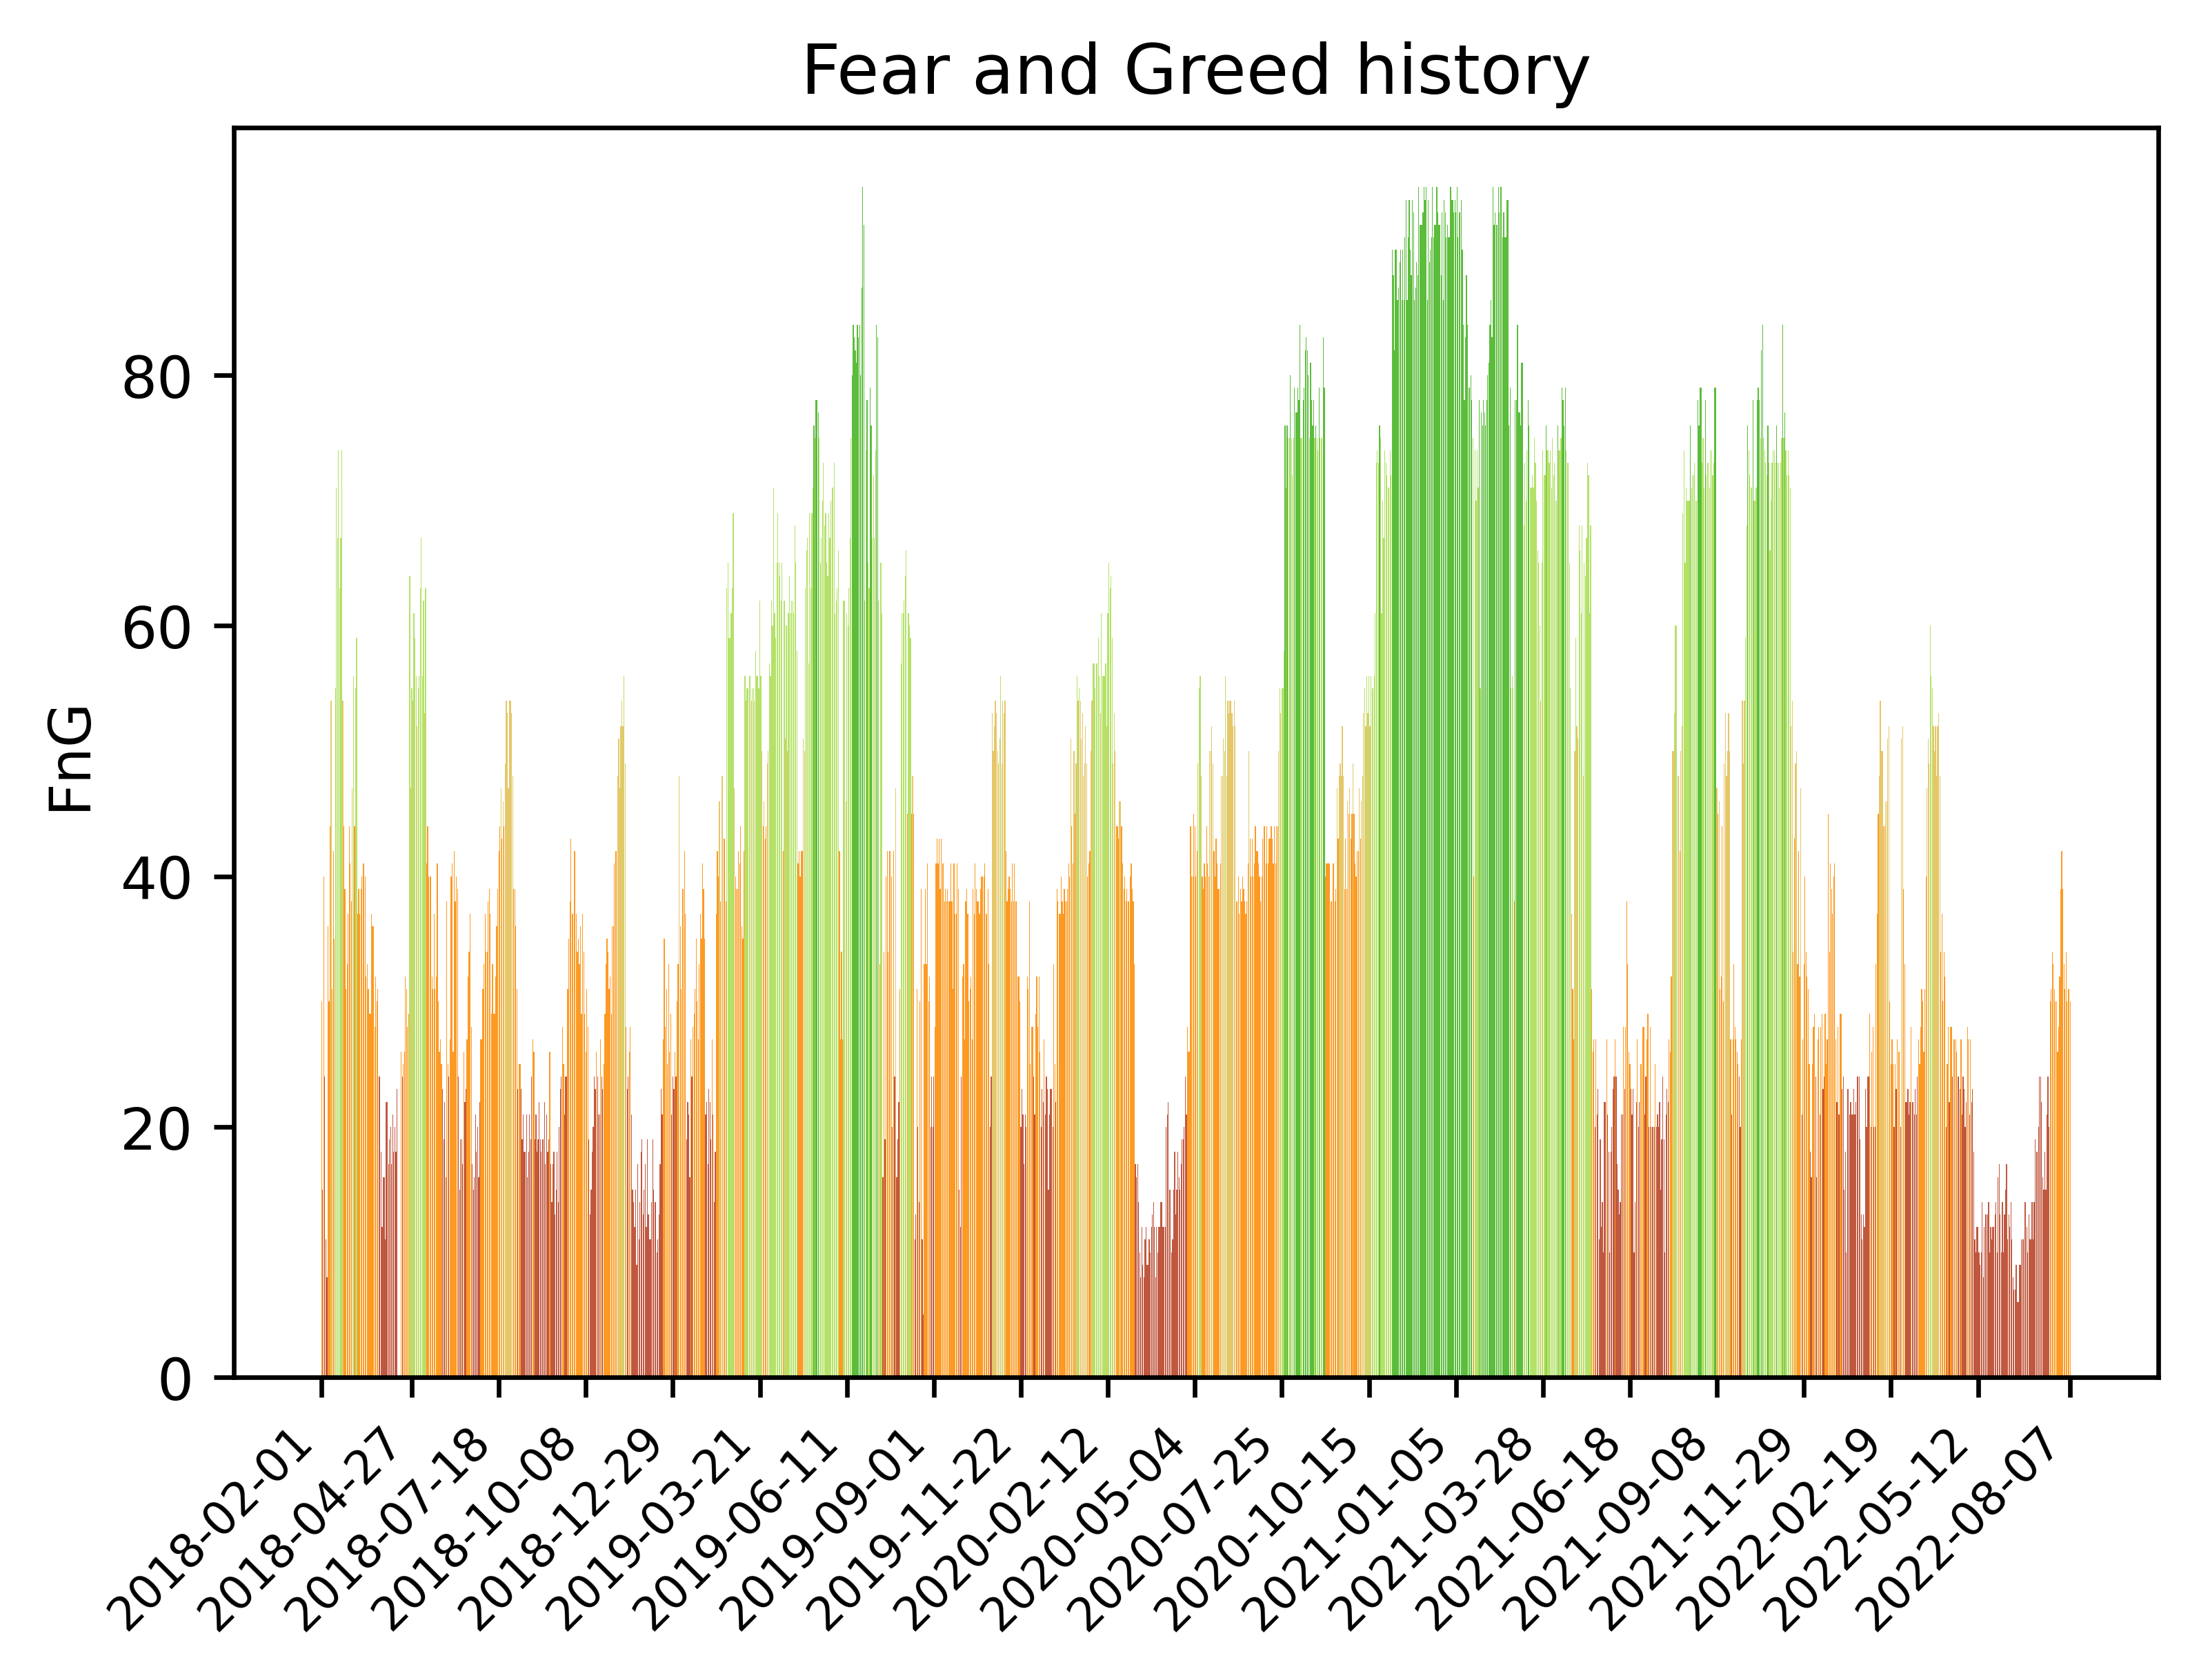

In [6]:
# fng.plot_fng(start_date='01/01/2020')
fng.plot_fng()